In [125]:
# ECG Analysis Pipeline: R-peak Detection and Anomaly Detection
# =============================================================================

import os
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, sosfiltfilt
from typing import Tuple, Optional, Dict
import gc

# Configuration
%matplotlib inline

# Download datasets if needed (commented out to avoid re-downloading)
# wfdb.dl_database("butqdb", "source1", keep_subdirs=False)
# wfdb.dl_database("nsrdb", "source2", keep_subdirs=False)


In [126]:

def filter_ecg(signal: np.ndarray, fs: int, low: float = 0.5, high: float = 40.0) -> np.ndarray:
    """Apply bandpass filter to ECG signal."""
    nyquist = 0.5 * fs
    sos = butter(4, [low/nyquist, high/nyquist], btype='band', output='sos')
    return sosfiltfilt(sos, signal)

def normalize_signal(signal: np.ndarray) -> np.ndarray:
    """Normalize signal to zero mean and unit variance."""
    return (signal - np.mean(signal)) / np.std(signal)

def preprocess_ecg(signal: np.ndarray, fs: int) -> np.ndarray:
    """Complete ECG preprocessing: filter and normalize."""
    filtered = filter_ecg(signal, fs)
    return normalize_signal(filtered)


In [127]:
def detect_r_peaks(signal: np.ndarray, fs: int) -> np.ndarray:
    """
    Detect R-peaks using Pan-Tompkins inspired algorithm.

    Args:
        signal: Preprocessed ECG signal
        fs: Sampling frequency

    Returns:
        Array of R-peak indices
    """
    # Differentiate and square
    diff = np.ediff1d(signal, to_end=0)
    squared = diff ** 2

    # Moving average integration
    window_size = int(0.08 * fs)  # 80ms window
    kernel = np.ones(window_size) / window_size
    integrated = np.convolve(squared, kernel, mode='same')

    # Find peaks with adaptive threshold
    threshold = np.percentile(integrated, 90)
    min_distance = int(0.3 * fs)  # 400ms minimum (150 BPM max)

    peaks, _ = find_peaks(integrated, height=threshold, distance=min_distance)

    # Refine peak locations in original signal
    r_peaks = []
    search_window = int(0.05 * fs)  # 50ms search window

    for peak in peaks:
        start = max(0, peak - search_window)
        end = min(len(signal), peak + search_window)
        if start < end:
            local_max = np.argmax(np.abs(signal[start:end])) + start
            r_peaks.append(local_max)

    return np.array(r_peaks)

def calculate_bpm(r_peaks: np.ndarray, fs: int, duration_sec: float,
                  window_sec: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate BPM in sliding windows."""
    if len(r_peaks) == 0:
        return np.array([]), np.array([])

    n_windows = int(duration_sec // window_sec)
    bpm_values = np.zeros(n_windows)

    for i in range(n_windows):
        start_sample = i * window_sec * fs
        end_sample = (i + 1) * window_sec * fs

        peaks_in_window = np.sum((r_peaks >= start_sample) & (r_peaks < end_sample))
        bpm_values[i] = peaks_in_window * 60 / window_sec

    time_minutes = np.arange(n_windows) * (window_sec / 60)
    return bpm_values, time_minutes

In [128]:
def load_ecg_file(file_path: str, max_duration_hours: Optional[float] = None) -> Tuple[np.ndarray, int]:
    """
    Load ECG file with optional duration limit.

    Returns:
        Tuple of (signal, sampling_rate)
    """
    header = wfdb.rdheader(file_path)
    fs = header.fs

    if max_duration_hours:
        max_samples = int(max_duration_hours * 3600 * fs)
        sampto = min(header.sig_len, max_samples)
    else:
        sampto = header.sig_len

    record = wfdb.rdrecord(file_path, sampto=sampto)

    # Get signal (use lead II if available, otherwise first lead)
    if len(record.p_signal.shape) > 1:
        if record.p_signal.shape[1] >= 2:
            signal = record.p_signal[:, 1]  # Lead II
        else:
            signal = record.p_signal[:, 0]  # First lead
    else:
        signal = record.p_signal

    return signal, fs

def analyze_ecg_file(data_dir: str, record_name: str, plot: bool = True,
                     max_duration_hours: Optional[float] = None) -> Dict:
    """
    Analyze single ECG file for R-peaks and BPM.

    Returns:
        Dictionary with analysis results
    """
    file_path = os.path.join(data_dir, f"{record_name}_ECG")

    try:
        # Load and preprocess signal
        signal, fs = load_ecg_file(file_path, max_duration_hours)
        processed_signal = preprocess_ecg(signal, fs)

        # Detect R-peaks
        r_peaks = detect_r_peaks(processed_signal, fs)

        # Calculate BPM
        duration_sec = len(signal) / fs
        bpm_values, time_minutes = calculate_bpm(r_peaks, fs, duration_sec)
        avg_bpm = np.mean(bpm_values) if len(bpm_values) > 0 else 0

        # Plot if requested
        if plot and len(bpm_values) > 0:
            plt.figure(figsize=(12, 4))
            plt.plot(time_minutes, bpm_values, '-', linewidth=1)
            plt.title(f"BPM Over Time - {record_name}")
            plt.xlabel("Time (minutes)")
            plt.ylabel("BPM")
            plt.grid(True, alpha=0.3)
            plt.show()

        # Results
        result = {
            'record_name': record_name,
            'success': True,
            'fs': fs,
            'total_samples': len(signal),
            'duration_hours': duration_sec / 3600,
            'r_peaks_detected': len(r_peaks),
            'average_bpm': avg_bpm,
            'bpm_values': bpm_values,
            'time_minutes': time_minutes
        }

        print(f"Processed {record_name}: {len(r_peaks)} R-peaks, {avg_bpm:.1f} BPM avg")
        return result

    except Exception as e:
        print(f"Error processing {record_name}: {e}")
        return {'record_name': record_name, 'success': False, 'error': str(e)}

    finally:
        gc.collect()

In [129]:
def analyze_ecg_batch(data_dir: str, max_files: Optional[int] = None,
                      max_duration_hours: Optional[float] = None) -> pd.DataFrame:
    """
    Process multiple ECG files in a directory.

    Args:
        data_dir: Directory containing ECG files
        max_files: Maximum number of files to process (None for all)
        max_duration_hours: Maximum duration per file in hours

    Returns:
        DataFrame with results summary
    """
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find ECG files
    ecg_files = [f for f in os.listdir(data_dir) if f.endswith('_ECG.hea')]
    record_names = sorted([f.replace('_ECG.hea', '') for f in ecg_files])

    if max_files:
        record_names = record_names[:max_files]

    print(f"Processing {len(record_names)} ECG files from {data_dir}")

    results = []
    for i, record_name in enumerate(record_names):
        print(f"File {i+1}/{len(record_names)}: {record_name}")

        result = analyze_ecg_file(data_dir, record_name, plot=False,
                                  max_duration_hours=max_duration_hours)

        if result.get('success', False):
            results.append({
                'Record': result['record_name'],
                'Sampling_Rate_Hz': result['fs'],
                'Duration_Hours': result['duration_hours'],
                'R_Peaks': result['r_peaks_detected'],
                'Average_BPM': result['average_bpm']
            })

        gc.collect()  # Memory cleanup

    return pd.DataFrame(results) if results else pd.DataFrame()

In [130]:
def detect_anomalies(signal: np.ndarray, method: str = 'zscore', threshold: float = 3.5) -> np.ndarray:
    """
    Detect anomalies in ECG signal.

    Args:
        signal: ECG signal
        method: 'zscore' or 'iqr'
        threshold: Threshold for anomaly detection

    Returns:
        Array of anomaly indices
    """
    if method == 'zscore':
        z_scores = np.abs((signal - np.mean(signal)) / np.std(signal))
        return np.where(z_scores > threshold)[0]

    elif method == 'iqr':
        q1, q3 = np.percentile(signal, [25, 75])
        iqr = q3 - q1
        if iqr == 0:
            return np.array([])
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        return np.where((signal < lower) | (signal > upper))[0]

    else:
        raise ValueError("Method must be 'zscore' or 'iqr'")

def analyze_anomalies(data_dir: str, record_name: str, plot: bool = True,
                      max_duration_hours: Optional[float] = None) -> Dict:
    """
    Detect and analyze anomalies in ECG file.

    Returns:
        Dictionary with anomaly detection results
    """
    file_path = os.path.join(data_dir, f"{record_name}_ECG")

    try:
        # Load and preprocess signal
        signal, fs = load_ecg_file(file_path, max_duration_hours)
        processed_signal = preprocess_ecg(signal, fs)

        # Detect anomalies
        anomalies = detect_anomalies(processed_signal, method='zscore', threshold=3.5)

        # Calculate statistics
        duration_hours = len(signal) / fs / 3600
        anomaly_rate = len(anomalies) / duration_hours if duration_hours > 0 else 0
        anomaly_times = anomalies / fs / 60  # Convert to minutes

        # Plot if requested
        if plot and len(anomalies) > 0:
            plt.figure(figsize=(12, 6))

            # Timeline plot
            plt.subplot(2, 1, 1)
            plt.scatter(anomaly_times, np.ones(len(anomaly_times)),
                       c='red', alpha=0.6, s=20)
            plt.title(f"Anomaly Timeline - {record_name} ({len(anomalies)} anomalies)")
            plt.xlabel("Time (minutes)")
            plt.ylabel("Anomalies")
            plt.grid(True, alpha=0.3)

            # Histogram
            plt.subplot(2, 1, 2)
            if len(anomaly_times) > 1:
                plt.hist(anomaly_times, bins=30, alpha=0.7, color='red')
                plt.title("Anomaly Distribution")
                plt.xlabel("Time (minutes)")
                plt.ylabel("Count")
                plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        result = {
            'record_name': record_name,
            'success': True,
            'anomalies_detected': len(anomalies),
            'anomaly_rate_per_hour': anomaly_rate,
            'duration_hours': duration_hours,
            'anomaly_times_minutes': anomaly_times
        }

        print(f"Anomalies in {record_name}: {len(anomalies)} ({anomaly_rate:.1f}/hour)")
        return result

    except Exception as e:
        print(f"Error analyzing anomalies in {record_name}: {e}")
        return {'record_name': record_name, 'success': False, 'error': str(e)}

    finally:
        gc.collect()

In [131]:
def evaluate_r_peak_detection(data_dir: str, record_name: str,
                              tolerance_ms: int = 150,
                              max_duration_hours: Optional[float] = None) -> Dict:
    """
    Evaluate R-peak detection against ground truth annotations.

    Args:
        data_dir: Directory containing test files
        record_name: Record name (without extension)
        tolerance_ms: Tolerance for peak matching in milliseconds
        max_duration_hours: Maximum duration to process

    Returns:
        Dictionary with evaluation metrics
    """
    file_path = os.path.join(data_dir, record_name)

    try:
        # Load signal and annotations
        signal, fs = load_ecg_file(file_path, max_duration_hours)

        # Load ground truth annotations
        annotations = wfdb.rdann(file_path, 'atr')
        true_peaks = annotations.sample

        # Limit to processed duration
        if max_duration_hours:
            max_samples = int(max_duration_hours * 3600 * fs)
            true_peaks = true_peaks[true_peaks < max_samples]

        # Detect R-peaks
        processed_signal = preprocess_ecg(signal, fs)
        detected_peaks = detect_r_peaks(processed_signal, fs)

        # Evaluate accuracy
        tolerance_samples = int((tolerance_ms / 1000) * fs)
        correct = 0

        for true_peak in true_peaks:
            distances = np.abs(detected_peaks - true_peak)
            if len(distances) > 0 and np.min(distances) <= tolerance_samples:
                correct += 1

        # Calculate metrics
        precision = correct / len(detected_peaks) if len(detected_peaks) > 0 else 0
        recall = correct / len(true_peaks) if len(true_peaks) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        result = {
            'record_name': record_name,
            'success': True,
            'true_peaks': len(true_peaks),
            'detected_peaks': len(detected_peaks),
            'correct_peaks': correct,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

        print(f"Evaluation {record_name}: P={precision:.3f}, R={recall:.3f}, F1={f1_score:.3f}")
        return result

    except Exception as e:
        print(f"Error evaluating {record_name}: {e}")
        return {'record_name': record_name, 'success': False, 'error': str(e)}

    finally:
        gc.collect()

def evaluate_batch(data_dir: str, max_files: Optional[int] = None,
                   max_duration_hours: Optional[float] = None) -> pd.DataFrame:
    """
    Evaluate R-peak detection on multiple files with ground truth.

    Returns:
        DataFrame with evaluation results
    """
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find files with annotations
    dat_files = [f for f in os.listdir(data_dir) if f.endswith('.dat')]
    record_names = sorted([f[:-4] for f in dat_files])

    if max_files:
        record_names = record_names[:max_files]

    print(f"Evaluating {len(record_names)} files from {data_dir}")

    results = []
    for record_name in record_names:
        result = evaluate_r_peak_detection(data_dir, record_name,
                                           max_duration_hours=max_duration_hours)

        if result.get('success', False):
            results.append({
                'File': result['record_name'],
                'True_Peaks': result['true_peaks'],
                'Detected_Peaks': result['detected_peaks'],
                'Correct_Peaks': result['correct_peaks'],
                'Precision': result['precision'],
                'Recall': result['recall'],
                'F1_Score': result['f1_score']
            })

        gc.collect()

    df = pd.DataFrame(results)

    if not df.empty:
        # Print summary statistics
        print(f"\nOverall Results:")
        print(f"Average Precision: {df['Precision'].mean():.3f}")
        print(f"Average Recall: {df['Recall'].mean():.3f}")
        print(f"Average F1-Score: {df['F1_Score'].mean():.3f}")

    return df


In [132]:
def run_ecg_pipeline(data_dir1: str = "source1", data_dir2: str = "source2",
                     max_duration_hours: float = 1.0, max_files: int = 5):
    """
    Run complete ECG analysis pipeline.

    Args:
        data_dir1: Directory for general ECG analysis
        data_dir2: Directory for evaluation (with annotations)
        max_duration_hours: Maximum duration per file
        max_files: Maximum files to process
    """
    print("=== ECG Analysis Pipeline ===")
    print(f"Processing up to {max_duration_hours}h per file, max {max_files} files\n")

    # 1. Single file analysis
    print("1. Single File Analysis")
    print("-" * 30)
    if os.path.exists(data_dir1):
        files = [f.replace('_ECG.hea', '') for f in os.listdir(data_dir1) if f.endswith('_ECG.hea')]
        if files:
            sample_file = files[0]
            analyze_ecg_file(data_dir1, sample_file, plot=True, max_duration_hours=max_duration_hours)

    # 2. Batch processing
    print("\n2. Batch Processing")
    print("-" * 30)
    batch_results = analyze_ecg_batch(data_dir1, max_files=max_files,
                                      max_duration_hours=max_duration_hours)
    if not batch_results.empty:
        print(f"\nBatch Results Summary:")
        print(batch_results)

    # 3. Anomaly detection
    print("\n3. Anomaly Detection")
    print("-" * 30)
    if os.path.exists(data_dir1) and files:
        analyze_anomalies(data_dir1, files[0], plot=True, max_duration_hours=max_duration_hours)

    # 4. Evaluation
    print("\n4. R-Peak Detection Evaluation")
    print("-" * 30)
    eval_results = evaluate_batch(data_dir2, max_files=max_files,
                                  max_duration_hours=max_duration_hours)
    if not eval_results.empty:
        print(f"\nEvaluation Results:")
        print(eval_results)

    print("\nPipeline completed!")

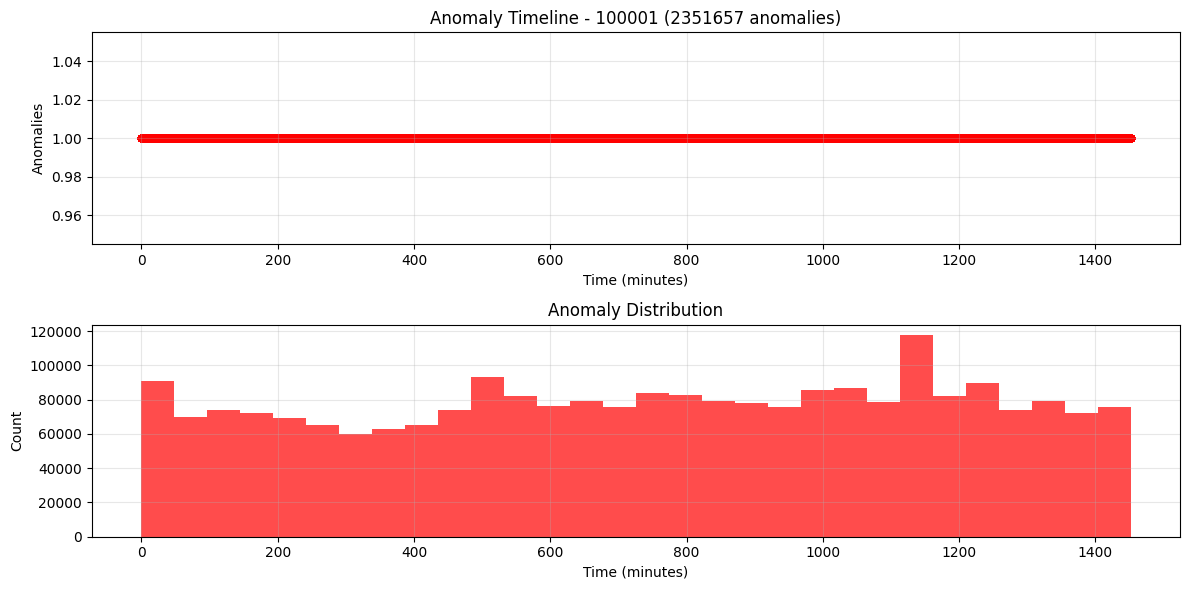

Anomalies in 100001: 2351657 (97212.7/hour)


{'record_name': '100001',
 'success': True,
 'anomalies_detected': 2351657,
 'anomaly_rate_per_hour': 97212.73209549072,
 'duration_hours': 24.190833333333334,
 'anomaly_times_minutes': array([5.03333333e-03, 5.05000000e-03, 5.06666667e-03, ...,
        1.45144612e+03, 1.45144613e+03, 1.45144615e+03], shape=(2351657,))}

In [133]:
# Run the complete pipeline
# run_ecg_pipeline()

# Or run individual components:
# analyze_ecg_file("source1", "100001", plot=True)
# batch_results = analyze_ecg_batch("source1")
analyze_anomalies("source1", "100001", plot=True)
# eval_results = evaluate_batch("source2")

# Example: Quick evaluation
# eval_results = evaluate_batch("source2", max_files=None, max_duration_hours=None)
# print(eval_results)